In [1]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
# %pip install earthengine-api --upgrade pandas geopandas > /dev/null
import folium
import json
import requests
import ee
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geopandas as gpd
# %matplotlib inline

ee.Authenticate()
ee.Initialize()


# Configurations

In [2]:
city_name = 'Sviatohirsk'
start_date = '2022-06-01'
end_date = '2022-09-13'
gdf_boundaries = gpd.read_file(f"./data/{city_name}_boundary.geojson")

In [3]:
# Get rectangular polygon of the boundaries of the city
city_bbox = gdf_boundaries.geometry.envelope
city_bbox = city_bbox.to_crs(epsg=4326)
# Plot both the city boundary and the city in folium, with center of the map being the centroid of the city
m = folium.Map(location=[city_bbox.centroid.y, city_bbox.centroid.x], zoom_start=14)
folium.GeoJson(city_bbox).add_to(m)
folium.GeoJson(gdf_boundaries).add_to(m)
m


/var/folders/yq/0zz796hs77l_70crv1b3x6z80000gn/T/ipykernel_54941/3662988411.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[city_bbox.centroid.y, city_bbox.centroid.x], zoom_start=14)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities

# Getting boundaries

In [4]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Define a method for displaying Earth Engine FeatureCollection tiles to folium map.
def add_ee_feature_collection_layer(self, ee_feature_collection, vis_params, name):
    # Convert the FeatureCollection to an Image for visualization purposes.
    # Here, we're assuming the features are polygons. Adjust the `style` function as needed.
    ee_image = ee.Image().paint(ee_feature_collection, 0, 2)  # 0 is the value to paint the features, 2 is the line width
    map_id_dict = ee_image.getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Add EE FeatureCollection drawing method to folium.
folium.Map.add_ee_feature_collection_layer = add_ee_feature_collection_layer

In [5]:
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

def det(im):
    """Calculates determinant of 2x2 diagonal covariance matrix."""
    return im.expression('b(0)*b(1)')

In [6]:
# Use city_bbox gdf to create an Earth Engine geometry, getting coordinates from the gdf
aoi = ee.Geometry.Polygon(list(city_bbox.iloc[0].exterior.coords))
aoi_sub = ee.Geometry.Polygon(list(city_bbox.iloc[0].buffer(-0.01).exterior.coords))

# Getting EE datasets

In [7]:
test_col = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date)))

# Show relativeOrbitNumber_start for the first image in the collection
relativeOrbitNumber_start = test_col.first().get('relativeOrbitNumber_start').getInfo()
# Show orbitProperties_pass for the first image in the collection
orbitProperties_pass = test_col.first().get('orbitProperties_pass').getInfo()
print(f"Orbit number: {relativeOrbitNumber_start}, pass: {orbitProperties_pass}")

im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
              .sort('system:time_start'))

timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d))).getInfo())
timestamplist

Orbit number: 167, pass: DESCENDING


['T20220601',
 'T20220613',
 'T20220625',
 'T20220707',
 'T20220719',
 'T20220731',
 'T20220812',
 'T20220905']

In [8]:
# For each date, make mosaic of images from that date
def make_mosaic(date):
    date = ee.Date(date)
    im = ee.Image(im_coll.filterDate(date, date.advance(1, 'day')).mosaic().clip(aoi))
    return im.set('system:time_start', date)

def get_first(date):
    date = ee.Date(date)
    im = ee.Image(im_coll.filterDate(date, date.advance(1, 'day')).first().clip(aoi))
    return im.set('system:time_start', date)

acq_times = im_coll.aggregate_array('system:time_start').getInfo()
im_coll = ee.ImageCollection.fromImages(list(map(make_mosaic, acq_times)))
im_list = im_coll.toList(im_coll.size())
im_list.length().getInfo()
# Show bands of 1st image
im = ee.Image(im_list.get(1))
im.bandNames().getInfo()

['VV', 'VH', 'angle']

In [9]:
def selectvv(current):
    return ee.Image(current).select('VV')

vv_list = im_list.map(selectvv)
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=14)
rgb_images = (ee.Image.rgb(vv_list.get(2), vv_list.get(0), vv_list.get(1))
              .log10().multiply(10))
mp.add_ee_layer(rgb_images, {'min': -20,'max': 0}, 'rgb composite')
mp.add_child(folium.LayerControl())

In [10]:
alpha = 0.01
print(f"{(1-(1-alpha)**(len(timestamplist)))*100}% of false positives - this we would get if we applied bitemporal method to each of the {len(timestamplist)} intervals")

7.7255305572079935% of false positives - this we would get if we applied bitemporal method to each of the 8 intervals


In [11]:
def omnibus(im_list, m = 4.4):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

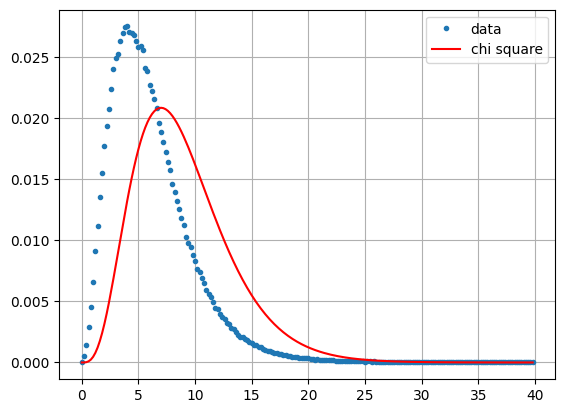

In [12]:
k = 10
hist = (omnibus(vv_list.slice(0,k))
        .reduceRegion(
          ee.Reducer.fixedHistogram(0, 40, 200), 
          geometry=aoi_sub, 
          scale=1, 
          maxPixels=3e9,
          bestEffort=True
        )
        .get('constant')
        .getInfo())

a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Define style function for GeoJSON layer
def style_function(feature):
    return {
        'fillColor': '#ffffff',  # Or whatever fill color you want
        'color': 'none',  # This removes the stroke
        'fillOpacity': 0.5,
        'weight': 0,
    }

# Add satellite image to the map
google_sat = folium.TileLayer(
    tiles='https://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=True,
    control=True,
    subdomains=['mt0', 'mt1', 'mt2', 'mt3']
)
# Pre-made folium map layer with bounds
bounds_layer = folium.GeoJson(gdf_boundaries, name='Bounds', style_function=lambda x: {'fillColor':'none'})

In [14]:
# The change map for alpha = 0.01.
k = 26; alpha = 0.01
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)
# Make the no-change pixels transparent.
c_map = c_map.updateMask(c_map.gt(0))
# Overlay onto the folium map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=14)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
# Add change map to the map
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'Change Map')
mp.add_child(folium.LayerControl())

In [15]:
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=14)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
mp.add_ee_layer(c_map, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0, 'max': 1, 'palette': ['black', 'blue']}, 'Change map (10m)')

mp.add_child(folium.LayerControl())

In [17]:
def sample_vv_imgs(j):
    """Samples the test statistics Rj in the region aoi_sub."""
    j = ee.Number(j)
    # Get the factors in the expression for Rj.
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0, j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0, j.subtract(1))).reduce(ee.Reducer.sum())
    # Put them together.
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)
    # Sample Rj.
    sample = (Rj.sample(region=aoi_sub, scale=10, numPixels=1000, seed=123)
              .aggregate_array('VV_sum'))
    return sample

# Sample the first few list indices.
samples = ee.List.sequence(2, 8).map(sample_vv_imgs)

# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)
# print(np.corrcoef(samples.getInfo()))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

In [18]:
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # Slice the series from k-l+1 to k (image indices start from 0).
        im_list_ell = im_list.slice(k.subtract(ell), k)

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})

        # Map over j=2,3,...,l.
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # Map over l = k to 2.
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

In [19]:
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # Create bmap band and add it to bmap image.
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # Filter Ql p value if desired.
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

In [20]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0, k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    return ee.Dictionary(pv_arr.iterate(filter_i, first))

In [21]:
result = change_maps(im_list, median=True, alpha=0.05)

# Extract the change maps and display.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'blue', 'cyan', 'yellow', 'red']
mp = folium.Map(location=location, zoom_start=14)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
mp.add_ee_layer(cmap, {'min': 0, 'max': 25, 'palette': palette}, 'cmap')
mp.add_ee_layer(smap, {'min': 0, 'max': 25, 'palette': palette}, 'smap')
mp.add_ee_layer(fmap, {'min': 0, 'max': 25, 'palette': palette}, 'fmap')
mp.add_child(folium.LayerControl())

In [22]:
def dmap_iter(current, prev):
    """Reclassifies values in directional change maps."""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # Reset avimg to current image and set i=1 if change occurred.
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

In [23]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

In [24]:
# Run the algorithm with median filter and at 1% significance.
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))
# Extract the change maps and export to assets.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
bmap = ee.Image(result.get('bmap'))
cmaps = ee.Image.cat(cmap, smap, fmap, bmap).rename(['cmap', 'smap', 'fmap']+timestamplist[1:])

In [25]:
# cmaps = ee.Image(assetId)
cmaps = cmaps.updateMask(cmaps.gt(0))

location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'red', 'cyan', 'yellow']

# Comment this code below out, as it will take a long time to run.
mp = folium.Map(location=location, zoom_start=14)
bounds_layer.add_to(mp)
google_sat.add_to(mp)
for timestamp in timestamplist[1:]:
    mp.add_ee_layer(cmaps.select(timestamp), {'min': 0,'max': 3, 'palette': palette}, timestamp)

mp.add_child(folium.LayerControl())

In [26]:
# We can export the change maps to Google Drive as GeoTIFFs.
export_to_drive = False

if export_to_drive:
    # Assuming `cmaps` is your image collection or image
    for timestamp in timestamplist[1:]:
        image = cmaps.select(timestamp)
        
        # Define export parameters
        task = ee.batch.Export.image.toDrive(**{
            'image': image,
            'description': f'{city_name}_change_map_full_{timestamp}',
            'folder': 'GEE_exports',  # Specify your Google Drive folder name
            'fileNamePrefix': f'{city_name}_change_map_full_{timestamp}',
            'scale': 10,
            'crs': 'EPSG:4326',
            'fileFormat': 'GeoTIFF',
            'maxPixels': 3e9  # Adjust as needed to avoid exceeding pixel limits,
        })
        
        # Start the export task
        task.start()

        print(f'Exporting {city_name}_change_map_full_{timestamp}.tif to Drive started.')

In [27]:
gdf = gpd.read_file(f"./data/{city_name}_msml_buildings.geojson")
gdf = gdf.to_crs(epsg=4326)
# leave only osm_id, display_name, geometry columns
gdf = gdf[['geometry']]
gdf

,geometry
0,"POLYGON ((37.54254 49.04200, 37.54266 49.04199..."
1,"POLYGON ((37.55587 49.03708, 37.55588 49.03705..."
2,"POLYGON ((37.55575 49.04455, 37.55565 49.04465..."
3,"POLYGON ((37.55660 49.04085, 37.55660 49.04096..."
4,"POLYGON ((37.55786 49.05185, 37.55786 49.05178..."
...,...
3931,"POLYGON ((37.57369 49.04367, 37.57359 49.04374..."
3932,"POLYGON ((37.57909 49.05329, 37.57922 49.05329..."
3933,"POLYGON ((37.58051 49.04159, 37.58061 49.04159..."
3934,"POLYGON ((37.58259 49.04544, 37.58269 49.04539..."


In [28]:

# Function to convert an ee.FeatureCollection to a GeoPandas GeoDataFrame
def ee_featurecollection_to_geopandas(fc):
    # Use getInfo() to get the GeoJSON data from the FeatureCollection
    fc_info = fc.getInfo()
    features = fc_info['features']
    geojson_dict = {'type': 'FeatureCollection', 'features': features}
    
    # Create a GeoPandas GeoDataFrame from the GeoJSON
    gdf = gpd.GeoDataFrame.from_features(geojson_dict)
    
    return gdf

In [29]:
import ee

export_as_gdf = False
export_as_gdrive = True

# Convert to ee.FeatureCollection
buildings = ee.FeatureCollection(gdf.__geo_interface__)
collections = []
for timestamp in timestamplist[1:]:
    # Function to extract average value from cmap for the entire area of each building
    def extract_value(feature):
        current = ee.Feature(feature)
        # Map over each image in the cmaps ImageCollection
        
        # Get the image for the current timestamp
        image = cmaps.select(timestamp)
        # Calculate the average value of the pixels under the footprint
        # Adjust 'scale' as necessary to match the resolution you're interested in
        value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=current.geometry(), scale=10).get(timestamp)
        # Set the property with a name derived from the timestamp
        # and the calculated value as its value
        return current.set(ee.String(f'value_{timestamp}'), value)
    
    # Apply the function to each building
    updated_buildings = buildings.map(extract_value)

    if export_as_gdrive:
        task = ee.batch.Export.table.toDrive(**{
                'collection': updated_buildings,
                'description':f'changes_{city_name}_{timestamp}',
                'folder': 'GEE_exports',  # Specify your Google Drive folder name
                'fileNamePrefix': f'changes_{city_name}_{timestamp}',
                'fileFormat': 'GeoJSON'
        })
        task.start()
        print(f'Exporting changes_{city_name}_{timestamp} to Drive started.')
    if export_as_gdf:
        gdf = ee_featurecollection_to_geopandas(updated_buildings)
        gdf = gdf.drop(columns=['geometry'])
        collections.append(gdf)

if export_as_gdf:
    # Merge all the GeoDataFrames into one
    gdf = pd.concat(collections, axis=1)
    gdf

Exporting changes_Sviatohirsk_T20220613 to Drive started.
Exporting changes_Sviatohirsk_T20220625 to Drive started.
Exporting changes_Sviatohirsk_T20220707 to Drive started.
Exporting changes_Sviatohirsk_T20220719 to Drive started.
Exporting changes_Sviatohirsk_T20220731 to Drive started.
Exporting changes_Sviatohirsk_T20220812 to Drive started.
Exporting changes_Sviatohirsk_T20220905 to Drive started.


In [30]:
if export_as_gdf:
    gdf.to_csv(f"./data/{city_name}_changes_buildings.csv", index=False)
    # Merge gdf with original gdf geometries, and export as geodataframe
    gpd.read_file(f"./data/{city_name}_msml_buildings.geojson").merge(gdf, left_index=True, right_index=True).to_file(f"./data/{city_name}_changes_buildings.geojson", driver='GeoJSON')

    # Plot the updated_buildings on a map
    mp = folium.Map(location=location, zoom_start=14)
    bounds_layer.add_to(mp)
    google_sat.add_to(mp)
    mp.add_ee_feature_collection_layer(updated_buildings, {}, 'Updated buildings')
    mp.add_child(folium.LayerControl())
    mp